# 토픽모델링을 통한 키워드 분석

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 사용할 라이브러리/데이터 불러오기 

In [2]:
!pip install konlpy pecab gensim
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 852 kB/s 
     |████████████████████████████████| 26.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 38.1 MB/s 
     |████████████████████████████████| 131 kB 69.0 MB/s 
  Created wheel for pecab: filename=pecab-1.0.2-py3-none-any.whl size=26646461 sha256=1e22abdbd876d8041270eb860ae2489a2e759fca6e76c4e4416ddfeb844c099c
  Stored in directory: /root/.cache/pip/wheels/57/e2/87/fe894d7193d71e94506f6bb86affe21bdfdebe8f6f2b665a1c
Successfully built pecab
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_au

In [3]:
import sys
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm  # progress bar
from konlpy.tag import Mecab; mecab = Mecab()
from konlpy.tag import Komoran; komoran = Komoran()

import numpy as np
import pandas as pd
import string
import re
import warnings
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

## 운영체제별 글꼴 세팅

# 그래프를 이쁘게 그리기 위한 코드입니다. 한글 글꼴을 추가합니다.

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns
mpl.rcParams['axes.unicode_minus'] = False

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져옵니다.
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

sys_font number: 17
['/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/libera

In [4]:
import sys
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm  # progress bar
from konlpy.tag import Mecab; mecab = Mecab()
from konlpy.tag import Komoran; komoran = Komoran()

import numpy as np
import pandas as pd
import string
import re
import warnings
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import seaborn as sns

%matplotlib inline

In [1]:
# Colab Notebooks

## 크롤링한 파일이 바뀌면, 경로도 수정되어야 합니다.
data_path = '/content/drive/MyDrive/Colab Notebooks/DScourse/week15/월드컵_(2022.10.01~2022.12.04).xlsx'

In [2]:
import pandas as pd

documents = pd.read_excel(data_path)['contents'].dropna() # 빈 문서 제거.
documents

0       '12년 만의 16강' 한국, 호화멤버 브라질 상대로 6일 '원정 8강 새역사' 도...
1       2022 카타르 월드컵 조별리그 H조 3차전 대한민국과 포르투갈 경기에서 권경원이 ...
2       기사내용 요약황희찬, 교체 26분 만에 골…안정환은 27분 걸려첫 한 대회 2경기 ...
3       네덜란드·칠레도 월드컵 본선서 세계 1위와 세 차례 만나브라질, 월드컵 16강전 패...
4       3일 오전(한국시간) 카타르 알라이얀의 에듀케이션 시티 스타디움에서 열린 2022 ...
                              ...                        
1563    A조에서는 네덜란드와 세네갈이 16강 진출…카타르는 3경기 전패    세네갈 쿨리발...
1564    독일, 조별리그 2차전까지 1무1패로 최하위코스타리카전 무조건 이겨야 16강행 가능...
1565    치킨[연합뉴스TV 제공]    (서울=연합뉴스) 신선미 기자 = 한국 축구대표팀의 ...
1566    16강 진출 확정한 브라질, 12월 2일 카메룬과 조별리그 최종전    세르비아전 ...
1567    김민재 '끝까지 쫓아간다'(알라이얀=연합뉴스) 임헌정 기자 = 24일 오후(현지시간...
Name: contents, Length: 1565, dtype: object

## 2. 전처리 함수 정의하기 

In [3]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    #doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer):
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    """
    # 불용어(SW)에 포함되어 있지 않고, 두 글자 이상인 token(형태소)만 사용하겠다.
    
    if tokenizer == "words":
        return [token for token in doc.split() if (token not in SW) and (len(token) >= 2)]
    
    elif tokenizer == "nouns":
        return [token for token in mecab.nouns(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 명사만 뽑아서 리스트로 반환.
        
    elif tokenizer == "morphs":
        return [token for token in mecab.morphs(doc) if (token not in SW) and (len(token) >= 2)] # 주어진 텍스트에서 형태소 단위로 잘라서 리스트로 반환.

In [5]:
tokenizer = 'nouns'
SW = define_stopwords('/content/drive/MyDrive/Colab Notebooks/DScourse/week15/stopwords-ko.txt')
tokenized_documents = [text_tokenizing(text_cleaning(doc), tokenizer=tokenizer) for doc in documents]

In [6]:
print(len(tokenized_documents))
print(tokenized_documents[0])

1565
['한국', '호화', '멤버', '브라질', '상대', '원정', '역사', '도전', '카타르', '월드컵', '진출', '태극', '전사', '알라', '연합뉴스', '임헌정', '기자', '오전', '한국', '카타르', '알라', '에듀케이션', '시티', '스타디움', '카타르', '월드컵', '조별', '리그', '대한민국', '포르투갈', '경기', '승리', '진출', '성공', '대표', '기념', '촬영', '기쁨', '도하', '연합뉴스', '진남', '기자', '월드컵', '진출', '한국', '축구', '사상', '원정', '대회', '도전', '상대', '세계', '최강', '브라질', '파울루', '벤투', '감독', '한국', '축구', '대표', '오전', '이하', '한국', '카타르', '도하', '스타디움', '브라질', '국제', '축구', '연맹', '카타르', '월드컵', '강전', '한국', '포르투갈', '조별', '리그', '마지막', '후반', '황희', '울버', '햄프턴', '결승', '역전승', '진출', '승점', '기록', '우루과이', '득실', '다득점', '우리나라', '포르투갈', '기적', '나라', '월드컵', '남아프리카', '공화국', '대회', '이후', '신화', '대회', '포함', '통산', '원정', '월드컵', '역사', '상대', '차지', '진출', '브라질', '올해', '월드컵', '본선', '참가', '통산', '최다', '우승', '차지', '축구', '강국', '랭킹', '한국', '카타르', '우승', '후보', '돌파', '주니오르', '루사일', '연합뉴스', '김주성', '기자', '오후', '현지', '카타르', '루사일', '스타디움', '카타르', '월드컵', '조별', '리그', '브라질', '세르비아', '경기', '브라질', '비니시우스', '주니오르', '세르비아', '파블로비치', '다툼', '선수', '면면', '최종', '명단', 

### gensim LDA model을 사용하기 위한 자료구조 생성. 

In [7]:
# 문서-단어 행렬 만들기
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_documents)
# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(document) for document in tokenized_documents]

In [8]:
NUM_TOTAL_WORDS = len(dictionary)
print(dictionary)
print(NUM_TOTAL_WORDS)

Dictionary(10554 unique tokens: ['가능', '가브리', '가치', '감독', '강국']...)
10554


## 3. 토픽 모델링(LDA Model)


- LDA(Latent Dirichlet Allocation) : 단어들의 조합(토픽)이 하나의 토픽을 구성하고, 각 단어가 그 토픽에 할당될 확률을 계산합니다.

- LDA는 사람이 글을 쓰는 과정을 다음과 같이 가정합니다.

1) 여러 개의 토픽을 정한다.

2) 토픽 하나를 고릅니다.

3) 토픽 내에 속하는 단어 하나를 고릅니다.

4) 해당 단어를 글에 적습니다.

5) 2번 과정부터 반복하면서 글을 적습니다.


-> LDA는 사람이 글을 쓰는 과정을 따라하면서 글을 생성하는 과정을 학습합니다. (Generative Model)

-> LDA는 생성을 통해서, 저자가 생각한 토픽의 분포(단어들의 확률 분포)를 찾습니다.

In [9]:
# ldamodel 선언
from gensim.models.ldamodel import LdaModel

# Coherence model 선언 (LDA의 정량 평가 지표.)
from gensim.models.coherencemodel import CoherenceModel

In [10]:
# 토픽 개수와 토픽 별 상위 추출 단어 개수 지정.

def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    print_log_msg("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def print_topic_words(model):
    """토픽별 토픽 단어들을 화면에 인쇄한다."""
    
    print_log_msg("Printing topic words.")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, 30)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))

        print("\n")


def print_log_msg(msg):
    """로그 메시지를 출력한다."""
    
    print(msg, flush=True)

In [11]:
def compute_coherence(dictionary, corpus, texts, start, end, step):
    '''
    start, end+1, step에 해당하는 토픽 개수를 입력받아서 LdaModel을 수행하고, 그 때의 Coherence Score를 함께 돌려주는 함수.
    '''
    coherence_score_list = []
    model_list = []
    for num_topics in tqdm(range(start, end+1, step)):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         passes=10,
                         random_state=42)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
        coherence_score_list.append(coherence_model.get_coherence())
        
    return model_list, coherence_score_list

In [12]:
# LDA에서 가장 중요한 파라미터 = K(토픽 개수)
start, end, step = [int(x) for x in input("원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)").split(",")]
start, end, step

원하는 토픽 갯수들을 입력하세요(e.g. 2,5,1)2,6,1


(2, 6, 1)

In [13]:
corpus, dictionary = build_doc_term_mat(tokenized_documents)
print(len(corpus), len(dictionary))


model_list, coherence_scores = compute_coherence(dictionary=dictionary, corpus=corpus, 
                                                texts=tokenized_documents, start=start, end=end, step=step)

Building document-term matrix.
1565 10554


  0%|          | 0/5 [00:00<?, ?it/s]

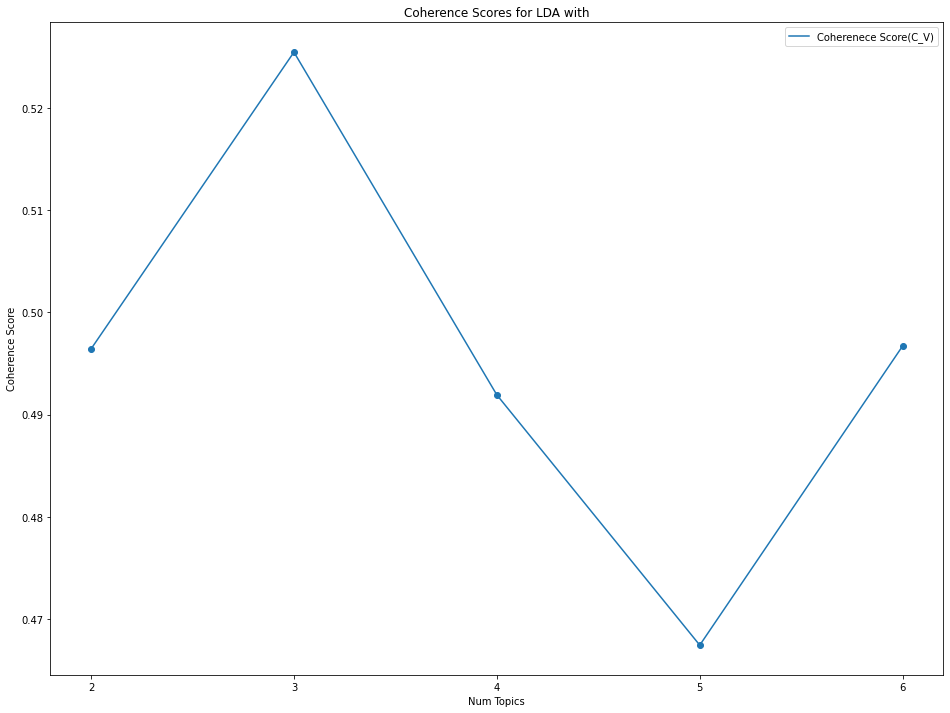

In [14]:
coherence_list = coherence_scores
label = "Coherenece Score(C_V)"

x = range(start, end+1, step)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.scatter(x, coherence_list)
plt.title(f"Coherence Scores for LDA with")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

In [15]:
selected_model = model_list[np.argmax(coherence_list)] # coherence score가 가장 높은 LDA model을 selected_model로 할당.
selected_model.num_topics

3

### 4. pyLDAvis를 이용한 시각화 

In [16]:
!pip install pyldavis==3.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 32.1 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136188 sha256=74b82e3d995d6ed43a3b728c38ba16ecb915a97283c9abd8d9ff1d4c4f5eec06
  Stored in directory: /root/.cache/pip/wheels/ae/5f/79/278ffb79ffde795f9686b558a8e313971ee0d3a914105d57dd
Successfully built pyldavis


In [17]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(selected_model, corpus, dictionary)
data

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.072497  0.065130       1        1  48.096918
0     -0.040372 -0.078784       2        1  30.948860
1      0.112870  0.013654       3        1  20.954222, topic_info=       Term         Freq        Total Category  logprob  loglift
208      일본  1736.000000  1736.000000  Default  30.0000  30.0000
72      브라질  2259.000000  2259.000000  Default  29.0000  29.0000
1135     메시   764.000000   764.000000  Default  28.0000  28.0000
291   아르헨티나   980.000000   980.000000  Default  27.0000  27.0000
276    네덜란드   664.000000   664.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
108    연합뉴스   289.503040  1602.547133   Topic3  -5.3337  -0.1484
177      한국   409.618338  6723.167987   Topic3  -4.9867  -1.2353
83       선수   300.116086  3005.902390   Topic3  -5.2977  -0.7413
23       기자   253.972766  2187.282892   Topic3  -5.4647  -0.5904
172    포르투갈   258.731245  3940.682728   Topic3  -5.4461  -1.1605

[255 rows x 6 columns], token_table=      Topic      Freq Term
term                      
223       1  0.902852   가나
223       2  0.074877   가나
223       3  0.022277   가나
1         2  0.971449  가브리
4160      2  0.971748  가오루
...     ...       ...  ...
2267      1  0.024737  훌리안
2267      3  0.964754  훌리안
1134      1  0.935045   휘슬
1134      2  0.046752   휘슬
1134      3  0.015584   휘슬

[450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])